## Fraud Detection Optimization ML Training

### Setup & Load Dataset

In [2]:
# Import libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve

from imblearn.over_sampling import SMOTE

In [3]:
# Load data

df = pd.read_csv('creditcard.csv')

In [4]:
# Drop duplicates

df.drop_duplicates(inplace=True)

In [5]:
# Basic info

print(df.shape)
print(df['Class'].value_counts())

(283726, 31)
Class
0    283253
1       473
Name: count, dtype: int64


### Feature Engineering

In [6]:
# Separate features/target

X = df.drop(['Class', 'Time'], axis=1)
y = df['Class']

# Scale 'Amount'

scaler = StandardScaler()
X['Amount'] = scaler.fit_transform(X['Amount'].values.reshape(-1, 1))

### EDA - Class Imbalance & Distributions

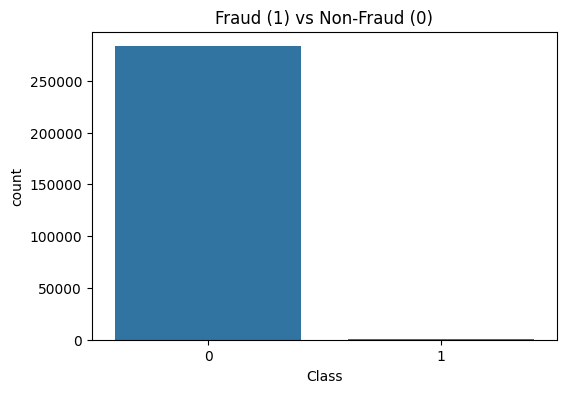

In [7]:
# Class distribution

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Class')
plt.title("Fraud (1) vs Non-Fraud (0)")
plt.show()

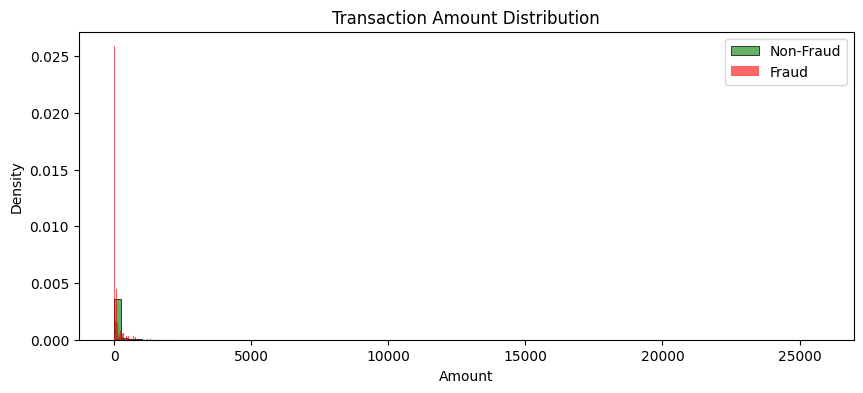

In [8]:
# Amount Distribution by Class

plt.figure(figsize=(10,4))
sns.histplot(data=df[df['Class']==0]['Amount'], bins=100, color='green', label='Non-Fraud', stat='density', alpha=0.6)
sns.histplot(data=df[df['Class']==1]['Amount'], bins=100, color='red', label='Fraud', stat='density', alpha=0.6)
plt.legend()
plt.title("Transaction Amount Distribution")
plt.show()

### Correlation & Time Patterns

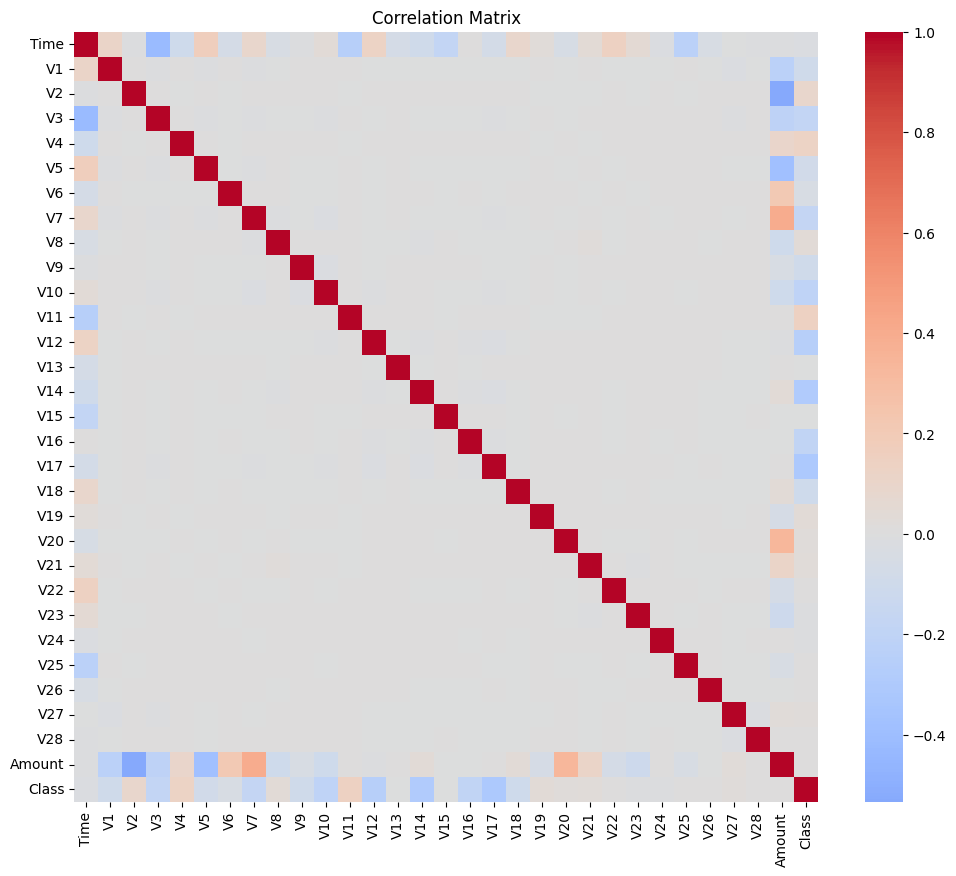

In [9]:
# Correlation heatmap

corr = df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Matrix")
plt.show()

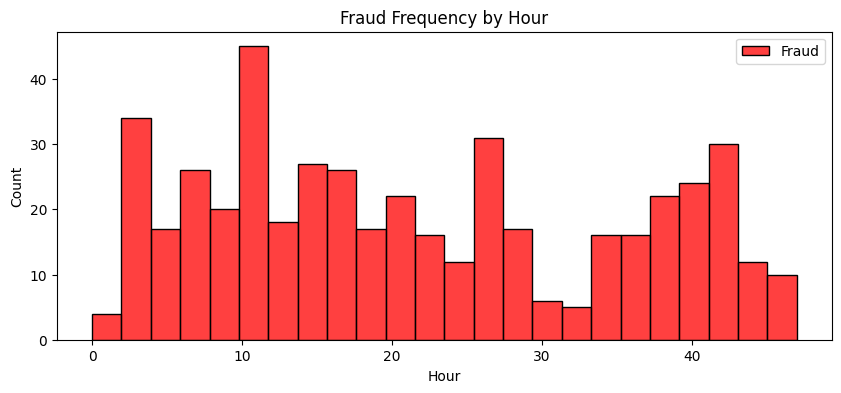

In [10]:
# Fraud over Time

df['Hour'] = df['Time'] // 3600
plt.figure(figsize=(10,4))
sns.histplot(data=df[df['Class']==1], x='Hour', bins=24, color='red', label='Fraud', stat='count')
plt.legend()
plt.title("Fraud Frequency by Hour")
plt.show()

### Train/Test Split + Apply SMOTE

In [11]:
# split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

Train size: (198608, 29), Test size: (85118, 29)


In [12]:
# Apply SMOTE only on training set

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Before SMOTE: {y_train.value_counts()}")
print(f"After SMOTE: {pd.Series(y_train_resampled).value_counts()}")

Before SMOTE: Class
0    198277
1       331
Name: count, dtype: int64
After SMOTE: Class
0    198277
1    198277
Name: count, dtype: int64


### Train Logistic Regression (Balanced)

In [13]:
model = LogisticRegression(max_iter=1000, solver='liblinear')
model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=1000, solver='liblinear')

### Evaluate on Original Test Set

In [14]:
y_pred = model.predict(X_test)
y_probs = model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9998    0.9723    0.9858     84976
           1     0.0504    0.8803    0.0953       142

    accuracy                         0.9721     85118
   macro avg     0.5251    0.9263    0.5406     85118
weighted avg     0.9982    0.9721    0.9844     85118



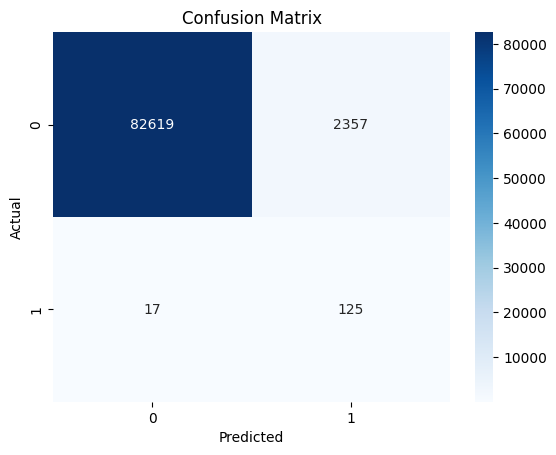

In [15]:
# Confusion matrix

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### ROC and PR Curves

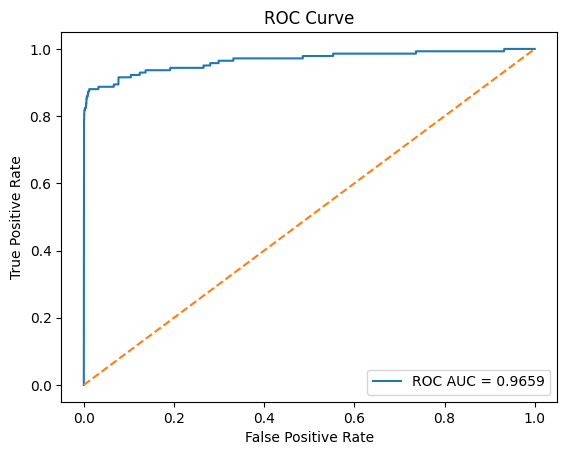

In [16]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc_score(y_test, y_probs):.4f}')
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC Curve")
plt.show()

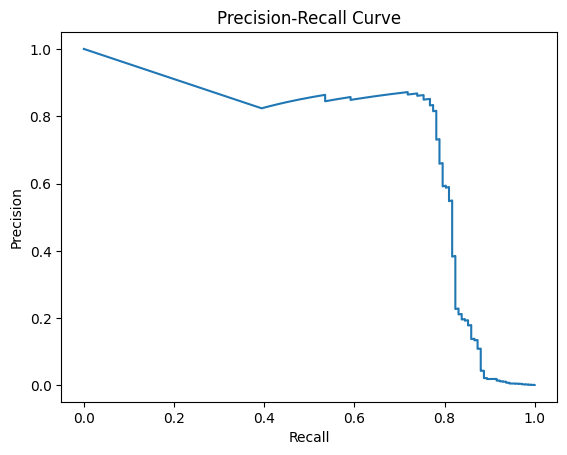

In [17]:
# PR Curve
precision, recall, _ = precision_recall_curve(y_test, y_probs)
plt.plot(recall, precision)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

### Train Random Forest Model

In [18]:
# Features & label
X = df.drop("Class", axis=1)
y = df["Class"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [19]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

In [20]:
# Train baseline Random Forest
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42)
rf_model.fit(X_train_smote, y_train_smote)

RandomForestClassifier(max_depth=8, random_state=42)

### Threshold Tuning Using F1 Score

In [21]:
import numpy as np

# Predict probabilities
y_probs = rf_model.predict_proba(X_test_scaled)[:, 1]

# Get precision-recall-thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

# Compute F1 for each threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
best_thresh = thresholds[np.argmax(f1_scores)]
print(f"Best Threshold: {best_thresh:.4f} | Best F1 Score: {max(f1_scores):.4f}")

# Predict with best threshold
y_pred_thresh = (y_probs >= best_thresh).astype(int)

Best Threshold: 0.8113 | Best F1 Score: 0.7955


### Evaluation Metrics

In [22]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_thresh)
print("Confusion Matrix:\n", cm)

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred_thresh, digits=4))

Confusion Matrix:
[[56640    11]
 [   25    70]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9996    0.9998    0.9997     56651
           1     0.8642    0.7368    0.7955        95

    accuracy                         0.9994     56746
   macro avg     0.9319    0.8683    0.8976     56746
weighted avg     0.9993    0.9994    0.9993     56746



In [23]:
# ROC AUC

auc_score = roc_auc_score(y_test, y_probs)
print(f"ROC AUC Score: {auc_score:.4f}")

ROC AUC Score: 0.9773


### Plot F1 vs Threshold

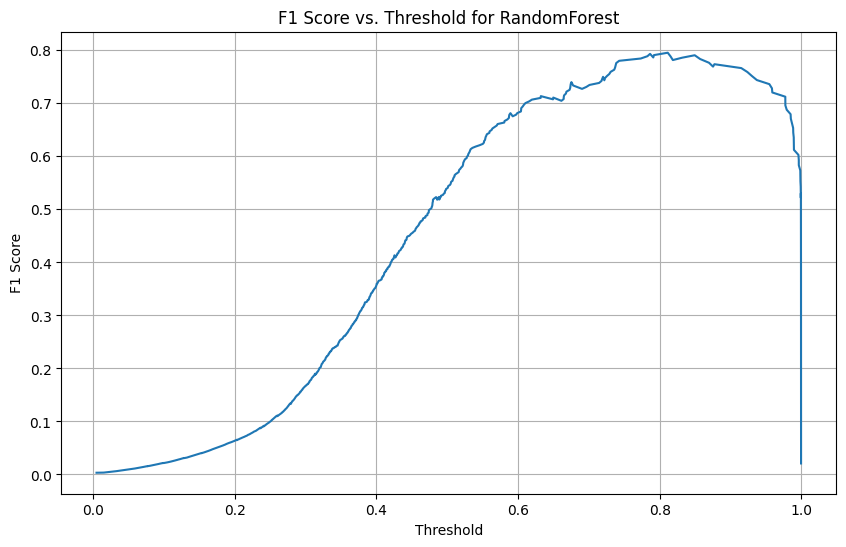

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores[:-1])
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Threshold for RandomForest")
plt.grid(True)
plt.show()

### Ensemble Stacking (RF + XGBoost + Logistic Regression)

In [26]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier

# SMOTE for balancing 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train_scaled, y_train)

In [27]:
# Define base learners
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=100, random_state=42)),
    ('lr', LogisticRegression(max_iter=500))
]

In [28]:
# Meta-learner: Logistic Regression
stack_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=LogisticRegression(max_iter=500),
    cv=5,
    n_jobs=-1
)

In [29]:
# Fit ensemble model
stack_model.fit(X_train_sm, y_train_sm)

StackingClassifier(cv=5,
                   estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None,
                                              feature_weights=None, gamma=Non...
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None, ...)),
                               ('lr', LogisticRegression(max_iter=500))],
                   final_estimator=LogisticRegression(max_iter=500), n_jobs=-1)

In [30]:
# Evaluate
y_pred = stack_model.predict(X_test_scaled)
print("ðŸ“Š Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nðŸ“„ Classification Report:")
print(classification_report(y_test, y_pred))

ðŸ“Š Confusion Matrix:
[[93459    15]
 [   34   122]]

ðŸ“„ Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93474
           1       0.89      0.78      0.83       156

    accuracy                           1.00     93630
   macro avg       0.95      0.89      0.92     93630
weighted avg       1.00      1.00      1.00     93630



### Save Model + Scaler

In [31]:
import os

# Create the models directory if it doesn't exist
os.makedirs("../models", exist_ok=True)

# Save model and scaler
joblib.dump(model, "../models/logreg_smote_model.pkl")
joblib.dump(scaler, "../models/scaler.pkl")
print("Saved model and scaler to '../models/'")

Saved model and scaler to '../models/'


In [32]:
# Save to a Custom Local Path

joblib.dump(model, "logreg_smote_model.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']